In [39]:
from urllib.request import urlopen
import dateutil.parser
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

def download(date_extension):
    url= 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date_extension +'.txt'
    print(url)
    response = urlopen(url)
    data = response.read()

    filename = 'data/' + date_extension + ".txt"
    file_ = open(filename, 'wb')
    file_.write(data)
    file_.close()


def calculate_dates(start, end):
    temp = []
    delta = datetime.timedelta(days=7)
    y1, m1, d1 = [int(x) for x in start.strip().split("-")]
    y2, m2, d2 = [int(y) for y in end.strip().split("-")]
    sDate = datetime.datetime(y1, m1, d1)
    eDate = datetime.datetime(y2, m2, d2)
    d = sDate
    while d <= eDate:
        temp.append(d)
        d += delta
        
    return temp


dates_download = calculate_dates('2016-06-25', '2017-06-24')
for i in dates_download:
    date_ext = i.strftime("%y%m%d")
    #download(date_ext)

In [40]:
def calculate_total_week(date, cumulative_df):
    
    date_extension = date.strftime("%y%m%d")
    filename = 'data/' + date_extension + '.txt'
    print(filename)
    df1 = pd.read_csv(filename)

    df1.columns = df1.columns.str.strip()
    # set the stations we want
    df = df1[(df1.STATION == 'TIMES SQ-42 ST') | (df1.STATION =='FLUSHING-MAIN' ) | (df1.STATION == 'ATL AV-BARCLAY')]
    df = df[df.DESC != 'RECOVR AUD']
    
    # start of analysis for weekly counts
    station_date = df.groupby(['C/A','UNIT','SCP','STATION','DATE'])
    entry_date_count = station_date.ENTRIES.apply(lambda x: x.max() - x.min())
    entry_date_count = entry_date_count.reset_index()

    exit_date_count = station_date.EXITS.apply(lambda x: x.max() - x.min())
    exit_date_count = exit_date_count.reset_index()

    # group all entries by station
    station_entry_week_count = entry_date_count.groupby('STATION').ENTRIES.agg(['sum'])
    station_exit_week_count = exit_date_count.groupby('STATION').EXITS.agg(['sum'])

    # total counts
    station_entry_week_count['exit sum'] = station_exit_week_count['sum']
    station_entry_week_count['total'] = station_entry_week_count['exit sum'] + station_entry_week_count['sum']
    station_entry_week_count['year_week'] = date
    station_entry_week_count = station_entry_week_count.reset_index()
    
    cumulative_df = cumulative_df.append(station_entry_week_count.iloc[:])
    return cumulative_df


# Run analysis
datesList = calculate_dates('2016-06-25', '2017-06-24')
final_week_count = pd.DataFrame()
for d in datesList:
    final_week_count = calculate_total_week(d, final_week_count)

data/160625.txt
data/160702.txt
data/160709.txt
data/160716.txt
data/160723.txt
data/160730.txt
data/160806.txt
data/160813.txt
data/160820.txt
data/160827.txt
data/160903.txt
data/160910.txt
data/160917.txt
data/160924.txt
data/161001.txt
data/161008.txt
data/161015.txt
data/161022.txt
data/161029.txt
data/161105.txt
data/161112.txt
data/161119.txt
data/161126.txt
data/161203.txt
data/161210.txt
data/161217.txt
data/161224.txt
data/161231.txt
data/170107.txt
data/170114.txt
data/170121.txt
data/170128.txt
data/170204.txt
data/170211.txt
data/170218.txt
data/170225.txt
data/170304.txt
data/170311.txt
data/170318.txt
data/170325.txt
data/170401.txt
data/170408.txt
data/170415.txt
data/170422.txt
data/170429.txt
data/170506.txt
data/170513.txt
data/170520.txt
data/170527.txt
data/170603.txt
data/170610.txt
data/170617.txt
data/170624.txt


In [41]:
final_week_count.to_csv(r'final_results.txt', header=True, sep=',')

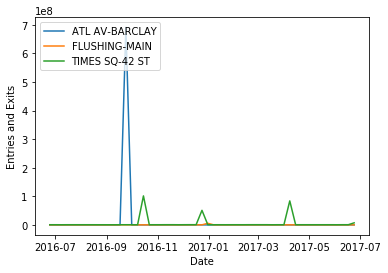

In [42]:
bp = final_week_count.groupby('STATION')
total = final_week_count['total']

atl_station = final_week_count[final_week_count.STATION == 'ATL AV-BARCLAY']
flushing_station = final_week_count[final_week_count.STATION == 'FLUSHING-MAIN']
times_station = final_week_count[final_week_count.STATION == 'TIMES SQ-42 ST']


#plt.ylim(ymax=np.percentile(final_week_count.total))
#final_outout = final_week_count.groupby('STATION')
plt.plot(atl_station.year_week, atl_station.total, label='ATL AV-BARCLAY')
plt.plot(flushing_station.year_week, flushing_station.total, label='FLUSHING-MAIN')
plt.plot(times_station.year_week, times_station.total, label='TIMES SQ-42 ST')
plt.xlabel('Date')
plt.ylabel('Entries and Exits')
plt.legend(loc='upper left')
#np.percentile(final_week_count.total, 99)


In [43]:
np.percentile(final_week_count.total, 99)

91667212.519999772